In [1]:
!pip install egg

In [2]:
%matplotlib inline

import os
import egg
import torch
from collections import Counter
from typing import List, Tuple, Dict, Optional
from torch import nn, Tensor
from torchvision.ops import box_convert
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

In [3]:
def resize_boxes(boxes: Tensor, original_size: List[int], new_size: List[int]) -> Tensor:
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

### Put interaction paths here

In [19]:
DA_model_path = "/Volumes/TOSHIBA/PhD/EmeComm/interactions/da_model.interaction"
TO_model_path = "/Volumes/TOSHIBA/PhD/EmeComm/interactions/to_model.interaction"

In [20]:
inter_DA = torch.load(DA_model_path)
inter_TO = torch.load(TO_model_path)

### Check which symbols have been used

In [21]:
msg_DA = inter_DA.message
n_batches_DA, bsz_DA, max_objs_DA = inter_DA.aux_input["mask"].shape
msg_DA = torch.argmax(msg_DA.view(n_batches_DA, bsz_DA, max_objs_DA, 2, -1), dim=-1)

msg_TO = inter_TO.message
n_batches_TO, bsz_TO, max_objs_TO = inter_TO.aux_input["mask"].shape
msg_TO = torch.argmax(msg_TO.view(n_batches_TO, bsz_TO, max_objs_TO, 2, -1), dim=-1)

In [22]:
def check_symbols(inter, msg):
    
    msg_pairs, msg_first_sym, msg_second_sym = [], [], []
    
    for batch_id, batch in enumerate(inter.aux_input['mask']):
        batch_msg = msg[batch_id]
        for mex, batch_elem in list(zip(batch_msg, batch)):
            for obj_mex, obj in list(zip(mex,batch_elem)):
                if obj == True:
                    msg_pairs.append(obj_mex.tolist())
                    msg_first_sym.append(int(obj_mex[0]))
                    msg_second_sym.append(int(obj_mex[1]))
                    
    return Counter(tuple(item) for item in msg_pairs).most_common(), \
           Counter(msg_first_sym).most_common(), \
           Counter(msg_second_sym).most_common()

#### We save the most frequent symbol pairs, first symbols, and second symbols

In [23]:
msg_pairs_DA, msg_first_sym_DA, msg_second_sym_DA = check_symbols(inter_DA, msg_DA)

In [11]:
msg_pairs_TO, msg_first_sym_TO, msg_second_sym_TO = check_symbols(inter_TO, msg_TO)

### Define variables and functions for the plotting

In [10]:
rcv_out_DA = inter_DA.receiver_output
rcv_out_DA = torch.argmax(rcv_out_DA.view(n_batches_DA, bsz_DA, max_objs_DA, -1), dim=-1)

rcv_out_TO = inter_TO.receiver_output
rcv_out_TO = torch.argmax(rcv_out_TO.view(n_batches_TO, bsz_TO, max_objs_TO, -1), dim=-1)

In [11]:
# define patches for our legend

red_patch = mpatches.Patch(color='red', label='target')
aqua_patch = mpatches.Patch(color='aqua', label='rec guess DA')
green_patch = mpatches.Patch(color='limegreen', label='rec guess TO')
fuchsia_patch = mpatches.Patch(color='fuchsia', label='attended DA')
blue_patch = mpatches.Patch(color='blue', label='distractors')

In [33]:
# define bboxes appearance

def image_target_box(image, tar):
    plt.figure(figsize=(10,10))
    plt.legend(handles=[red_patch, aqua_patch, green_patch, fuchsia_patch, blue_patch], fontsize=10)
    plt.imshow(image)
    plt.gca().add_patch(Rectangle((tar[0], tar[1]), tar[2], tar[3], edgecolor='red', facecolor='none', lw = 5))

def aqua_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-0.3, obj[1]-0.3), obj[2]-0.6, obj[3]-0.6, edgecolor='aqua', facecolor='none', lw = 4))
    
def green_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-1, obj[1]-1), obj[2]+2.5, obj[3]+2.5, edgecolor='limegreen', facecolor='none', lw = 4))

def fuchsia_box(obj):
    plt.gca().add_patch(Rectangle((obj[0]-0.6, obj[1]-0.6), obj[2]+1.6, obj[3]+1.6, edgecolor='fuchsia', facecolor='none', lw = 4))
    
def blue_box(obj):
    plt.gca().add_patch(Rectangle((obj[0], obj[1]), obj[2], obj[3], edgecolor='blue', facecolor='none', lw = 3))

In [34]:
# define rules for bbox colors

def color_rule(transormed_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj):
    if idx_other_obj == rcv_idx_DA:
        aqua_box(other_obj)                                       
    if idx_other_obj == rcv_idx_TO:
        green_box(other_obj)                                     
        if idx_other_obj == torch.argmax(att_out_DA):
        fuchsia_box(other_obj)                                
    if idx_obj != idx_other_obj:
        blue_box(other_obj)

In [35]:
# define our assertion rule that we'll use to make sure that: 
# when the model guesses, the output object is equal to the target
def assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_model):
    if idx_other_obj == rcv_idx_model:
        assert other_obj.tolist() == obj.tolist(), "Mismatch guess!"

## Visual analysis of symbol pairs

In [36]:
def visual_analysis_2sym(symbol1, symbol2, batch_id, guessed_DA, guessed_TO):

    for this_batch_id, batch in enumerate(msg_DA):
        if this_batch_id == batch_id:
            for idx_img, img, or_size, bboxes in list(zip(range(0,len(inter_DA.aux_input["sender_image"])),
                                            inter_DA.aux_input['sender_image'][this_batch_id],  
                                            inter_DA.aux_input["image_sizes"][this_batch_id],
                                            inter_DA.aux_input['bboxes'][this_batch_id])):
    
                or_w, or_h = or_size.tolist()[0][1], or_size.tolist()[0][2]
                xyxy = box_convert(bboxes, "xywh", "xyxy") 
                t_boxes = resize_boxes(xyxy, (or_w, or_h), (128,128))
                t_xywh = box_convert(t_boxes, "xyxy", "xywh") 
                image = img.permute(1, 2, 0)
                                 
                for idx_obj, mex, bbox, mask, guess_DA, obj, rcv_idx_DA, rcv_idx_TO, att_out_DA, in list(zip(range(0,len(inter_DA.aux_input["bboxes"])),
                                        msg_DA[this_batch_id][idx_img],
                                        inter_DA.aux_input['bboxes'][this_batch_id][idx_img],
                                        inter_DA.aux_input['mask'][this_batch_id][idx_img],
                                        inter_DA.aux_input['guesses'][this_batch_id][idx_img],
                                        t_xywh,
                                        rcv_out_DA[this_batch_id][idx_img],
                                        rcv_out_TO[this_batch_id][idx_img],
                                        inter_DA.aux_input["attn_weights"][this_batch_id][idx_img][0])): 
                    
                    if mask == True:
                        if guessed_DA == "yes": # IF DA HAS GUESSED
                            if guessed_TO == "yes": # IF TO HAS GUESSED
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA == 1.0 and rcv_idx_TO != idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        
                        elif guessed_DA == "no":
                            if guessed_TO == "yes": # IF TO HAS GUESSED:
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):                
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED:         
                                if mex[0] == symbol1 and mex[1] == symbol2 and guess_DA != 1.0 and rcv_idx_TO != idx_obj:         
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):       
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                    
                    
                        plt.show()

In [43]:
# to check which symbols we want to search for

# the first two numbers are the symbol pair, the third number is the n of occurrences 
msg_pairs_DA

[((2812, 3418), 1180),
 ((1798, 3418), 1116),
 ((29, 3418), 1076),
 ((1884, 3418), 1069),
 ((2071, 3418), 1044),
 ((2529, 3418), 1000),
 ((3628, 3418), 959),
 ((3636, 3418), 948),
 ((3583, 3418), 937),
 ((3723, 3418), 926),
 ((3675, 3418), 900),
 ((3197, 3418), 783),
 ((3327, 3418), 774),
 ((2893, 3418), 744),
 ((2605, 3418), 705),
 ((1187, 3418), 683),
 ((3723, 751), 617),
 ((3636, 751), 596),
 ((3121, 3418), 585),
 ((1920, 3418), 574),
 ((1670, 3418), 524),
 ((2605, 751), 523),
 ((1798, 751), 505),
 ((373, 3418), 504),
 ((2754, 3418), 469),
 ((3675, 751), 454),
 ((373, 751), 421),
 ((2071, 935), 420),
 ((1884, 935), 419),
 ((3121, 751), 412),
 ((2812, 935), 407),
 ((3583, 935), 398),
 ((123, 3418), 385),
 ((1117, 3418), 385),
 ((1798, 935), 369),
 ((3628, 935), 368),
 ((3636, 935), 363),
 ((29, 935), 359),
 ((3675, 935), 356),
 ((2529, 935), 355),
 ((1670, 751), 352),
 ((3723, 935), 340),
 ((367, 751), 326),
 ((2529, 751), 323),
 ((2071, 751), 318),
 ((2812, 751), 311),
 ((3197, 751)

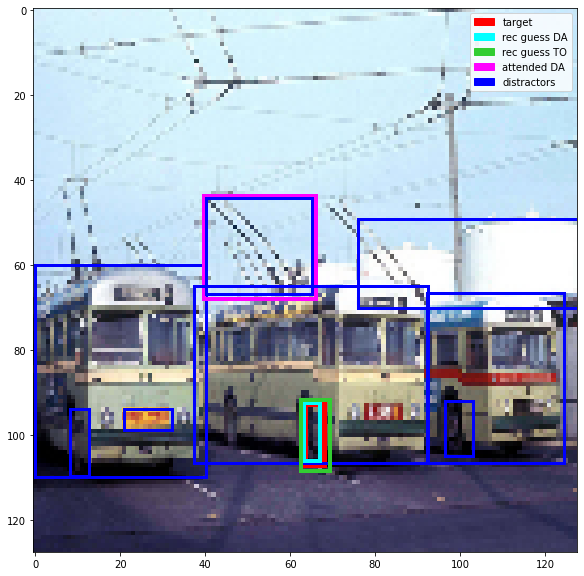

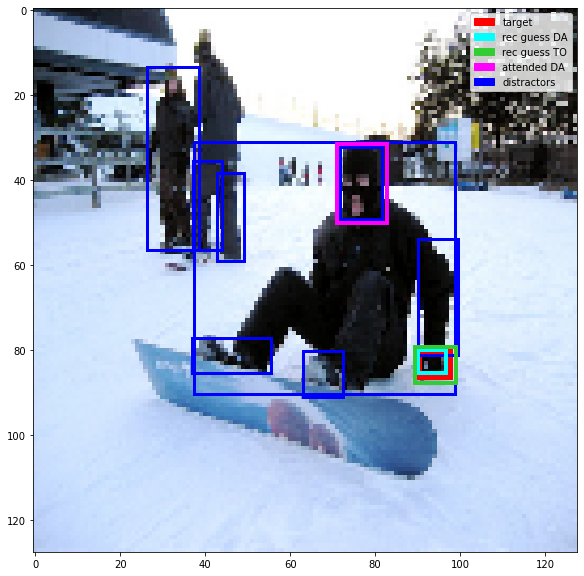

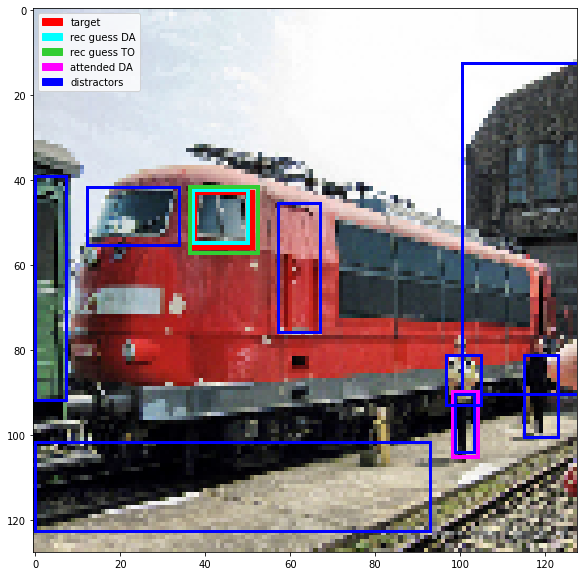

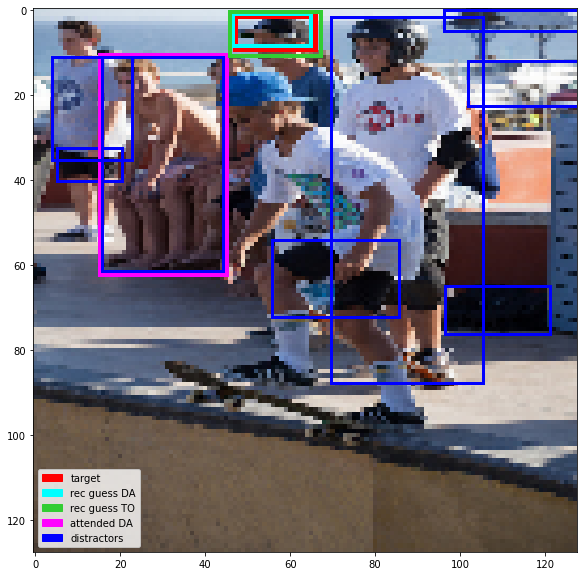

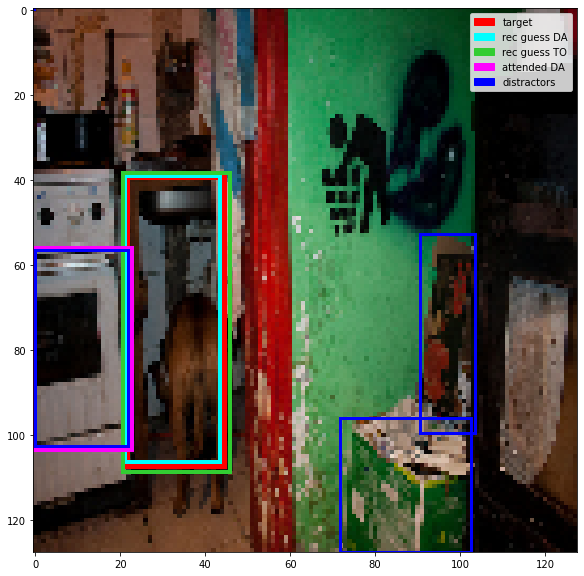

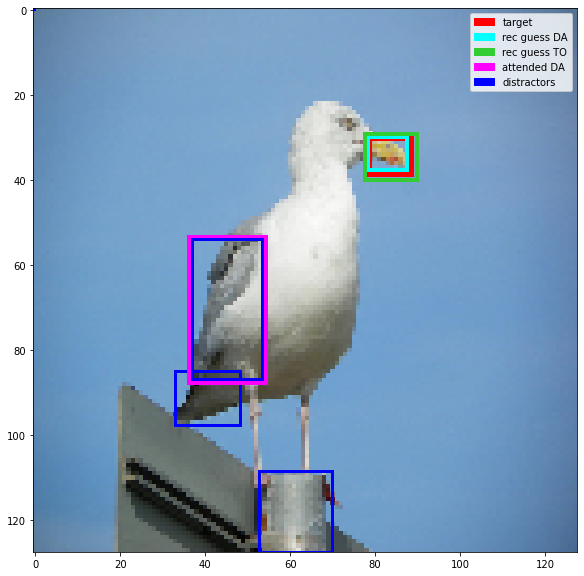

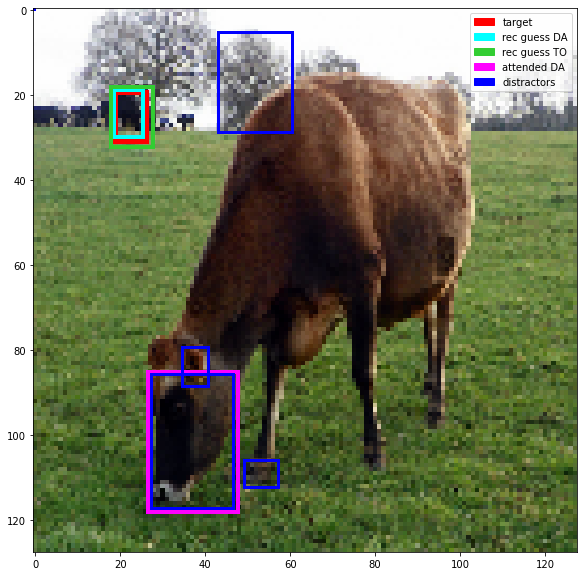

KeyboardInterrupt: 

In [37]:
symbol1 = 2812  
symbol2 = 751
guessed_DA = "yes"
guessed_TO = "yes"

for check_batch in range(0,10): # change here the range to check more batches
    visual_analysis_2sym(symbol1, symbol2, check_batch, guessed_DA, guessed_TO) 

## Visual analysis of one symbol

In [38]:
def visual_analysis_1sym(symbol, symbol_position, batch_id, guessed_DA, guessed_TO):

    for this_batch_id, batch in enumerate(msg_DA):
        if this_batch_id == batch_id:
            for idx_img, img, or_size, bboxes in list(zip(range(0,len(inter_DA.aux_input["sender_image"])),
                                            inter_DA.aux_input['sender_image'][this_batch_id],  
                                            inter_DA.aux_input["image_sizes"][this_batch_id],
                                            inter_DA.aux_input['bboxes'][this_batch_id])):
    
                or_w, or_h = or_size.tolist()[0][1], or_size.tolist()[0][2]
                xyxy = box_convert(bboxes, "xywh", "xyxy") 
                t_boxes = resize_boxes(xyxy, (or_w, or_h), (128,128))
                t_xywh = box_convert(t_boxes, "xyxy", "xywh") 
                image = img.permute(1, 2, 0)
                                 
                for idx_obj, mex, bbox, mask, guess_DA, obj, rcv_idx_DA, rcv_idx_TO, att_out_DA, in list(zip(range(0,len(inter_DA.aux_input["bboxes"])),
                                        msg_DA[this_batch_id][idx_img],
                                        inter_DA.aux_input['bboxes'][this_batch_id][idx_img],
                                        inter_DA.aux_input['mask'][this_batch_id][idx_img],
                                        inter_DA.aux_input['guesses'][this_batch_id][idx_img],
                                        t_xywh,
                                        rcv_out_DA[this_batch_id][idx_img],
                                        rcv_out_TO[this_batch_id][idx_img],
                                        inter_DA.aux_input["attn_weights"][this_batch_id][idx_img][0])): 
                    
                    if mask == True:
                        if guessed_DA == "yes": # IF DA HAS GUESSED
                            if guessed_TO == "yes": # IF TO HAS GUESSED
                                if mex[symbol_position] == symbol and guess_DA == 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED
                                if mex[symbol_position] == symbol and guess_DA == 1.0 and rcv_idx_TO != idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)     
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_DA)
                                        
                        elif guessed_DA == "no":
                            if guessed_TO == "yes": # IF TO HAS GUESSED:
                                if mex[symbol_position] == symbol and guess_DA != 1.0 and rcv_idx_TO == idx_obj:
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):                
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                        assertion_rule(other_obj, obj, idx_other_obj, rcv_idx_TO)
                                        
                            if guessed_TO == "no": # IF TO HAS NOT GUESSED:         
                                if mex[symbol_position] == symbol and guess_DA != 1.0 and rcv_idx_TO != idx_obj:         
                                    image_target_box(image, obj)
                                    for idx_other_obj, other_obj in list(enumerate(t_xywh)):       
                                        color_rule(t_boxes, idx_other_obj, rcv_idx_DA, other_obj, obj, rcv_idx_TO, att_out_DA, idx_obj)
                                    
                    
                        plt.show()

In [40]:
# to check which symbols we want to search for

# The first number is the symbol, the second number is the n of occurrences

msg_first_sym_DA # options: msg_first_sym_DA, msg_second_sym_DA

[(1798, 2219),
 (3636, 2167),
 (3723, 2138),
 (2812, 2116),
 (2071, 2049),
 (1884, 1971),
 (3675, 1947),
 (29, 1923),
 (2529, 1882),
 (3583, 1817),
 (3628, 1809),
 (2605, 1636),
 (3197, 1536),
 (2893, 1504),
 (3327, 1471),
 (3121, 1385),
 (1187, 1366),
 (373, 1258),
 (1670, 1200),
 (1920, 1074),
 (2754, 914),
 (1117, 789),
 (123, 778),
 (367, 774),
 (1185, 73),
 (1281, 10),
 (1938, 1)]

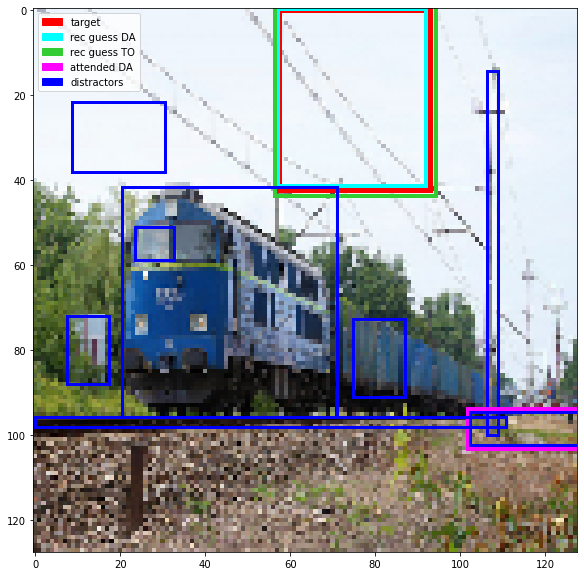

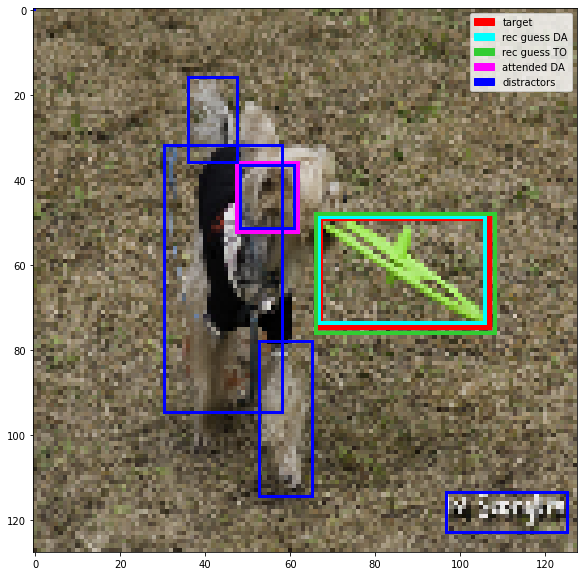

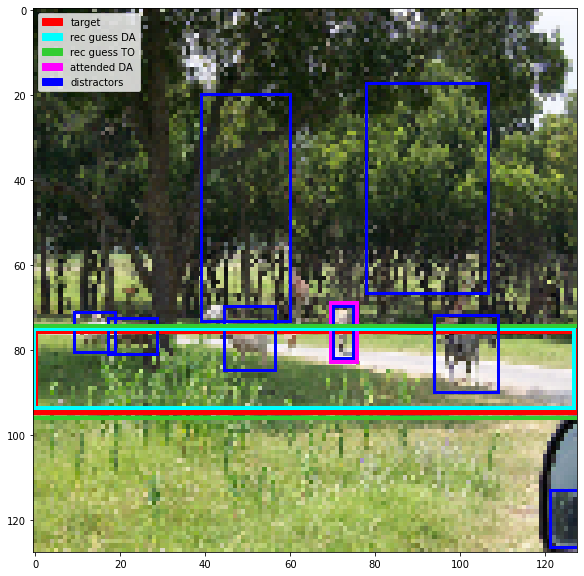

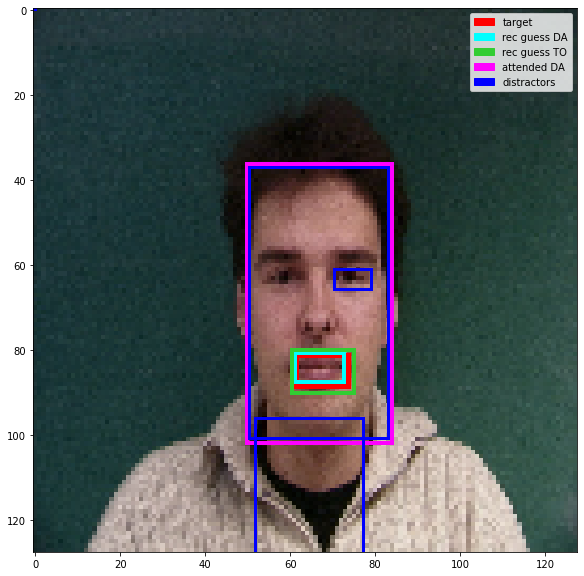

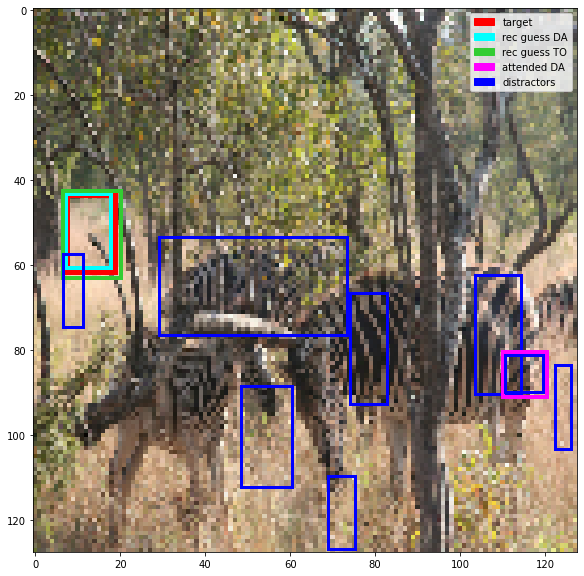

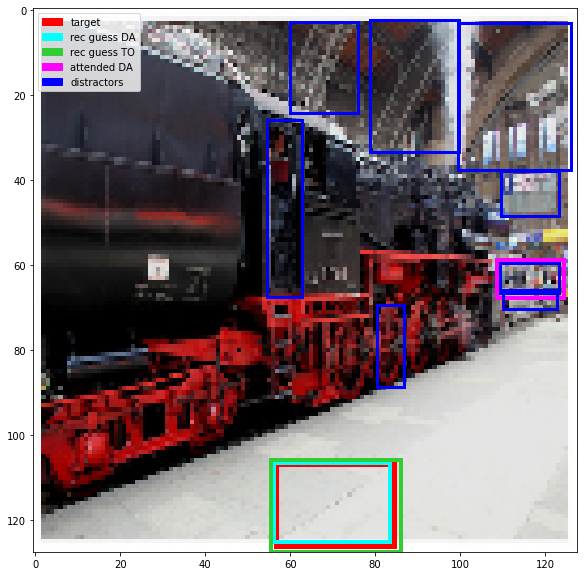

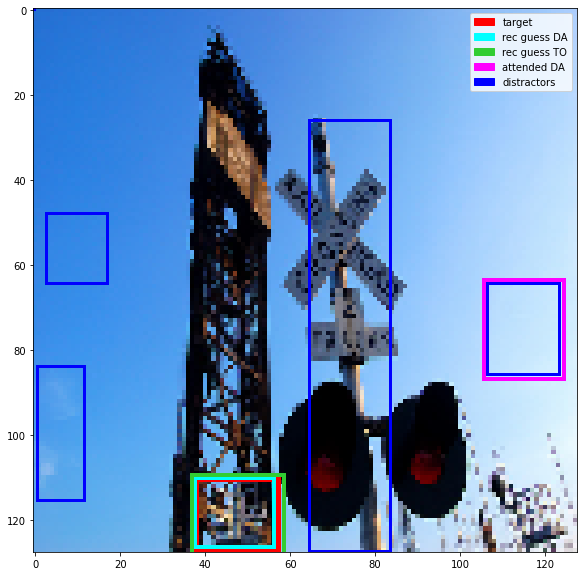

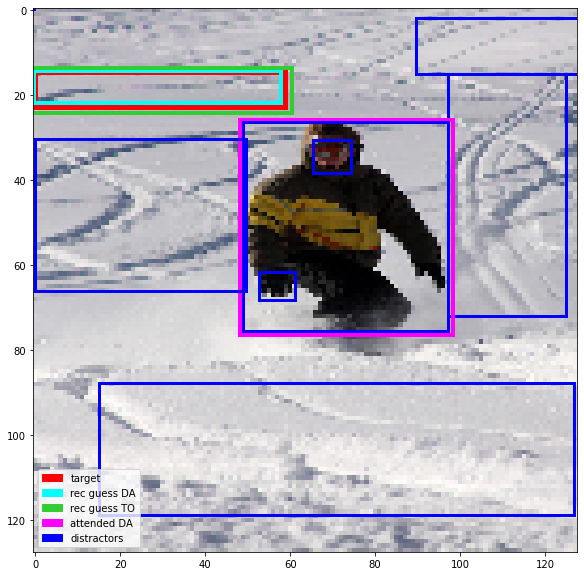

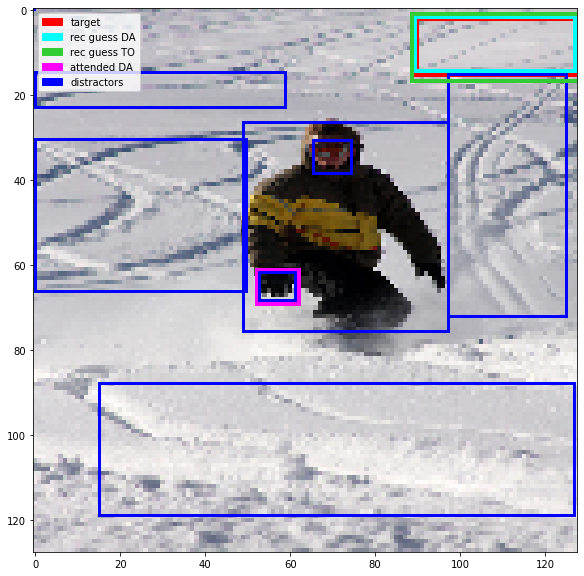

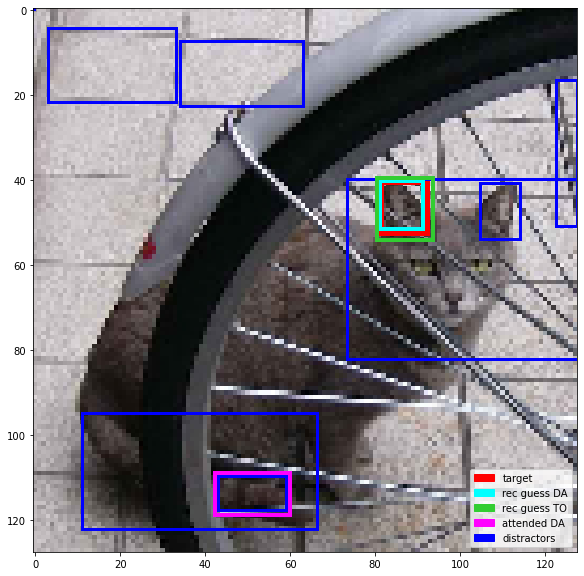

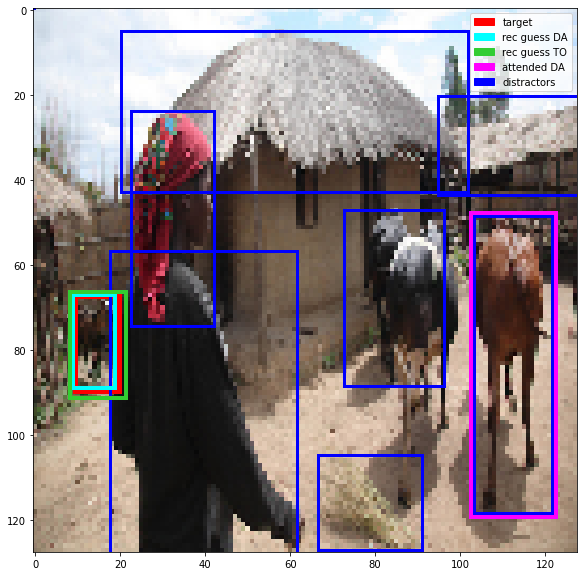

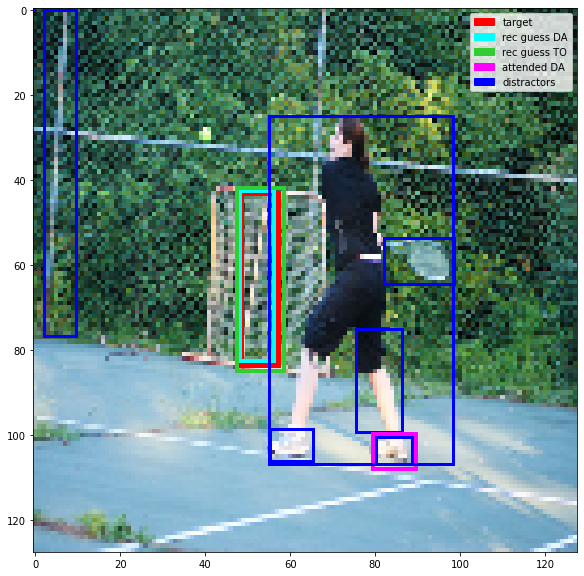

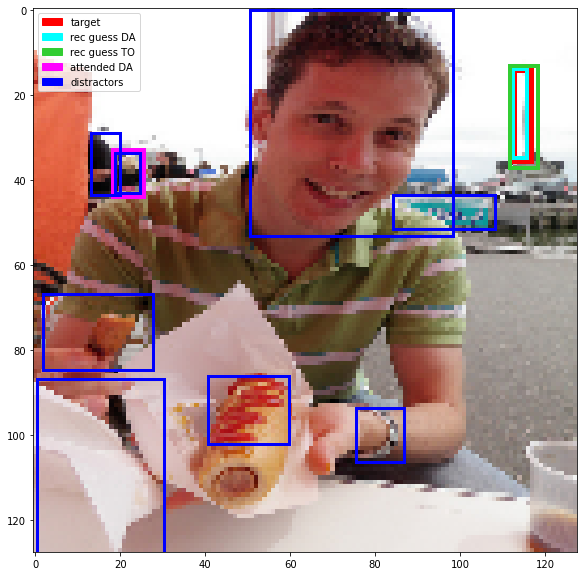

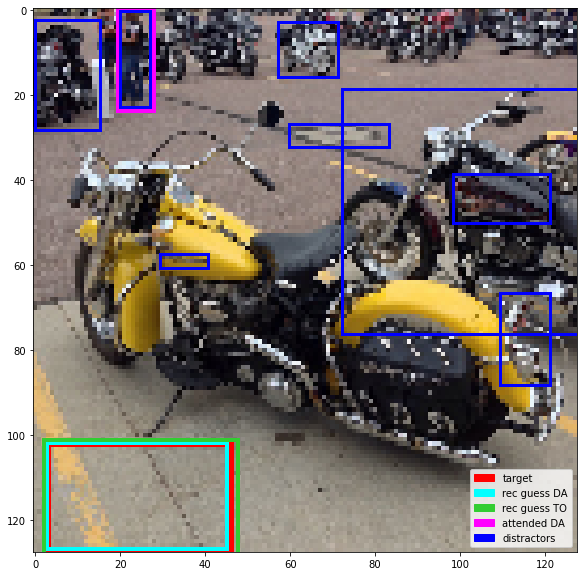

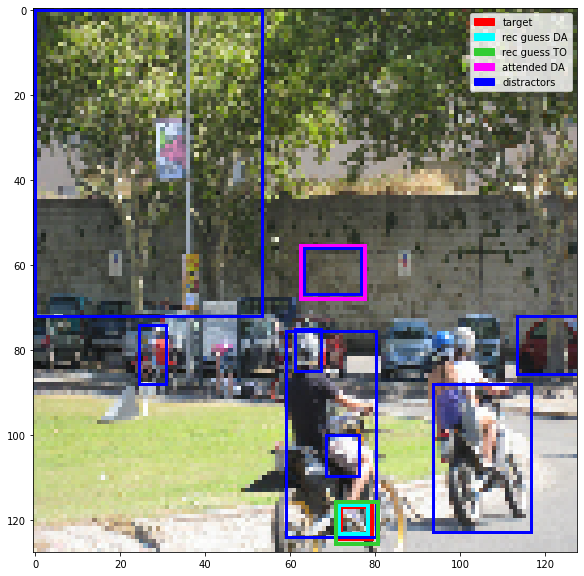

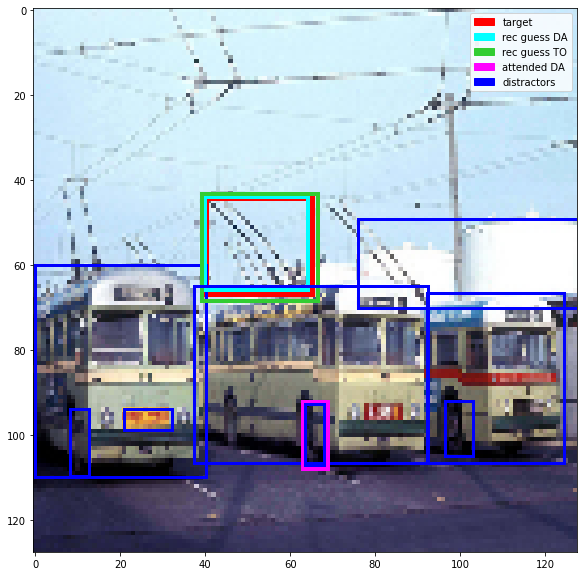

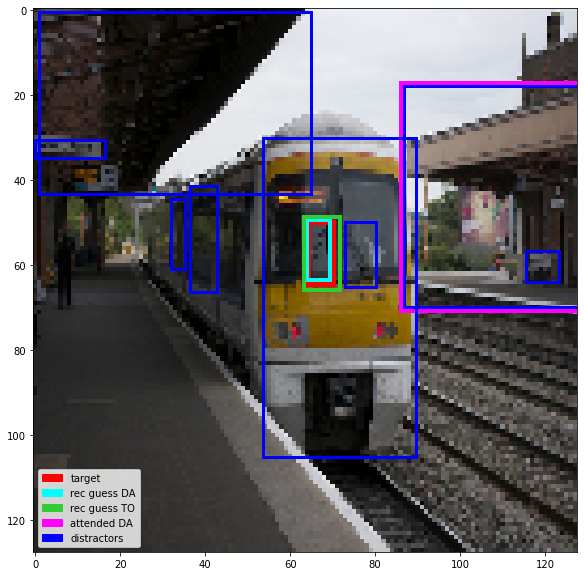

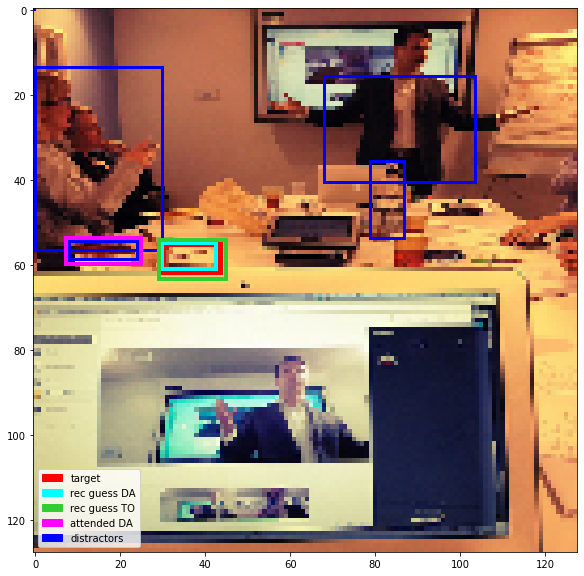

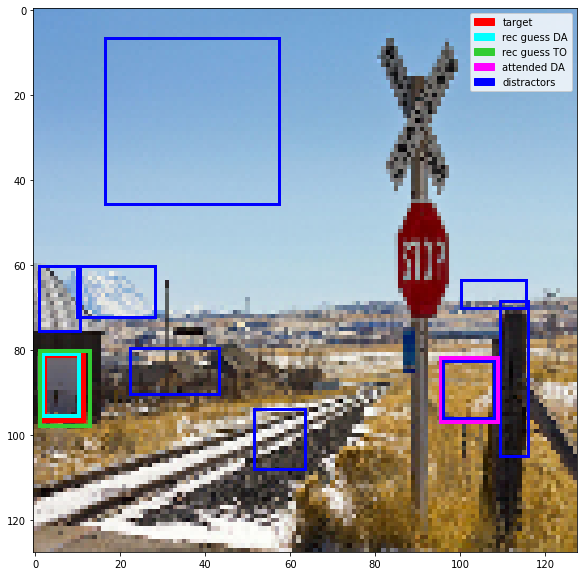

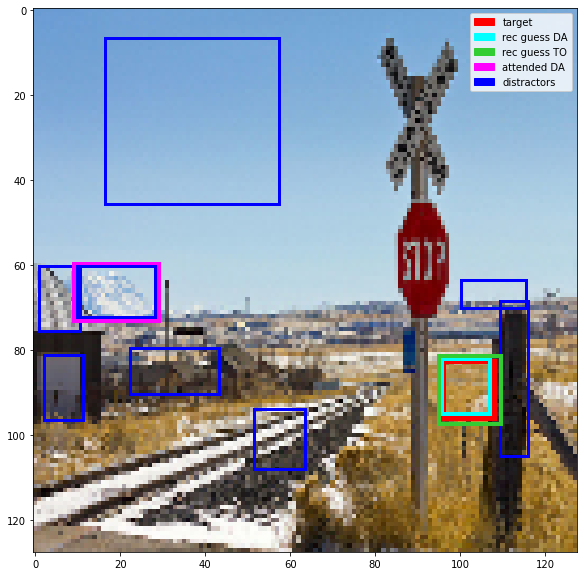

KeyboardInterrupt: 

In [41]:
symbol = 1798 
symbol_position = 0 # to check first symbol: position 0; second symbol: position 1
guessed_DA = "yes"
guessed_TO = "yes"

for check_batch in range(0,10): # change here the range to check more batches
    visual_analysis_1sym(symbol, symbol_position, check_batch, guessed_DA, guessed_TO) 